In [1]:
import os 
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture  as GMM
import matplotlib.pyplot as plt

In [3]:
def read_group(gdir):
    data = pd.read_csv(os.path.join(gdir,"paras.csv"))
    name = data.title.tolist()
    fitline = []
    for namei in name:
        fitline.append(
            np.load(os.path.join(gdir, f"{namei}.npy"))
        )
    
    values = data.drop(columns=["title"]).values
    ln_values = np.log(values)
    return name, ln_values, fitline

In [4]:
dataroot=os.path.join("data","fit")
gs = []
for d, _, f in os.walk(dataroot):
    if len(f):
        gs.append(d)
print(gs)

dataname, paras, y, lines, fromwhere = [], None, [], [], []

for idx, di in enumerate(gs):
    
    name, p ,l = read_group(di)
    
    for n in name:
        y.append(idx)
        fromwhere.append(di)
        dataname.append(n)
    for li in l:
        lines.append(li)

    if paras is None:
        paras = p
    else:
        paras = np.concatenate((paras, p), axis=0)

['data\\fit\\91', 'data\\fit\\president', 'data\\fit\\recall', 'data\\fit\\referendum']


In [5]:
vis=TSNE().fit_transform(paras)

d:\py\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\py\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


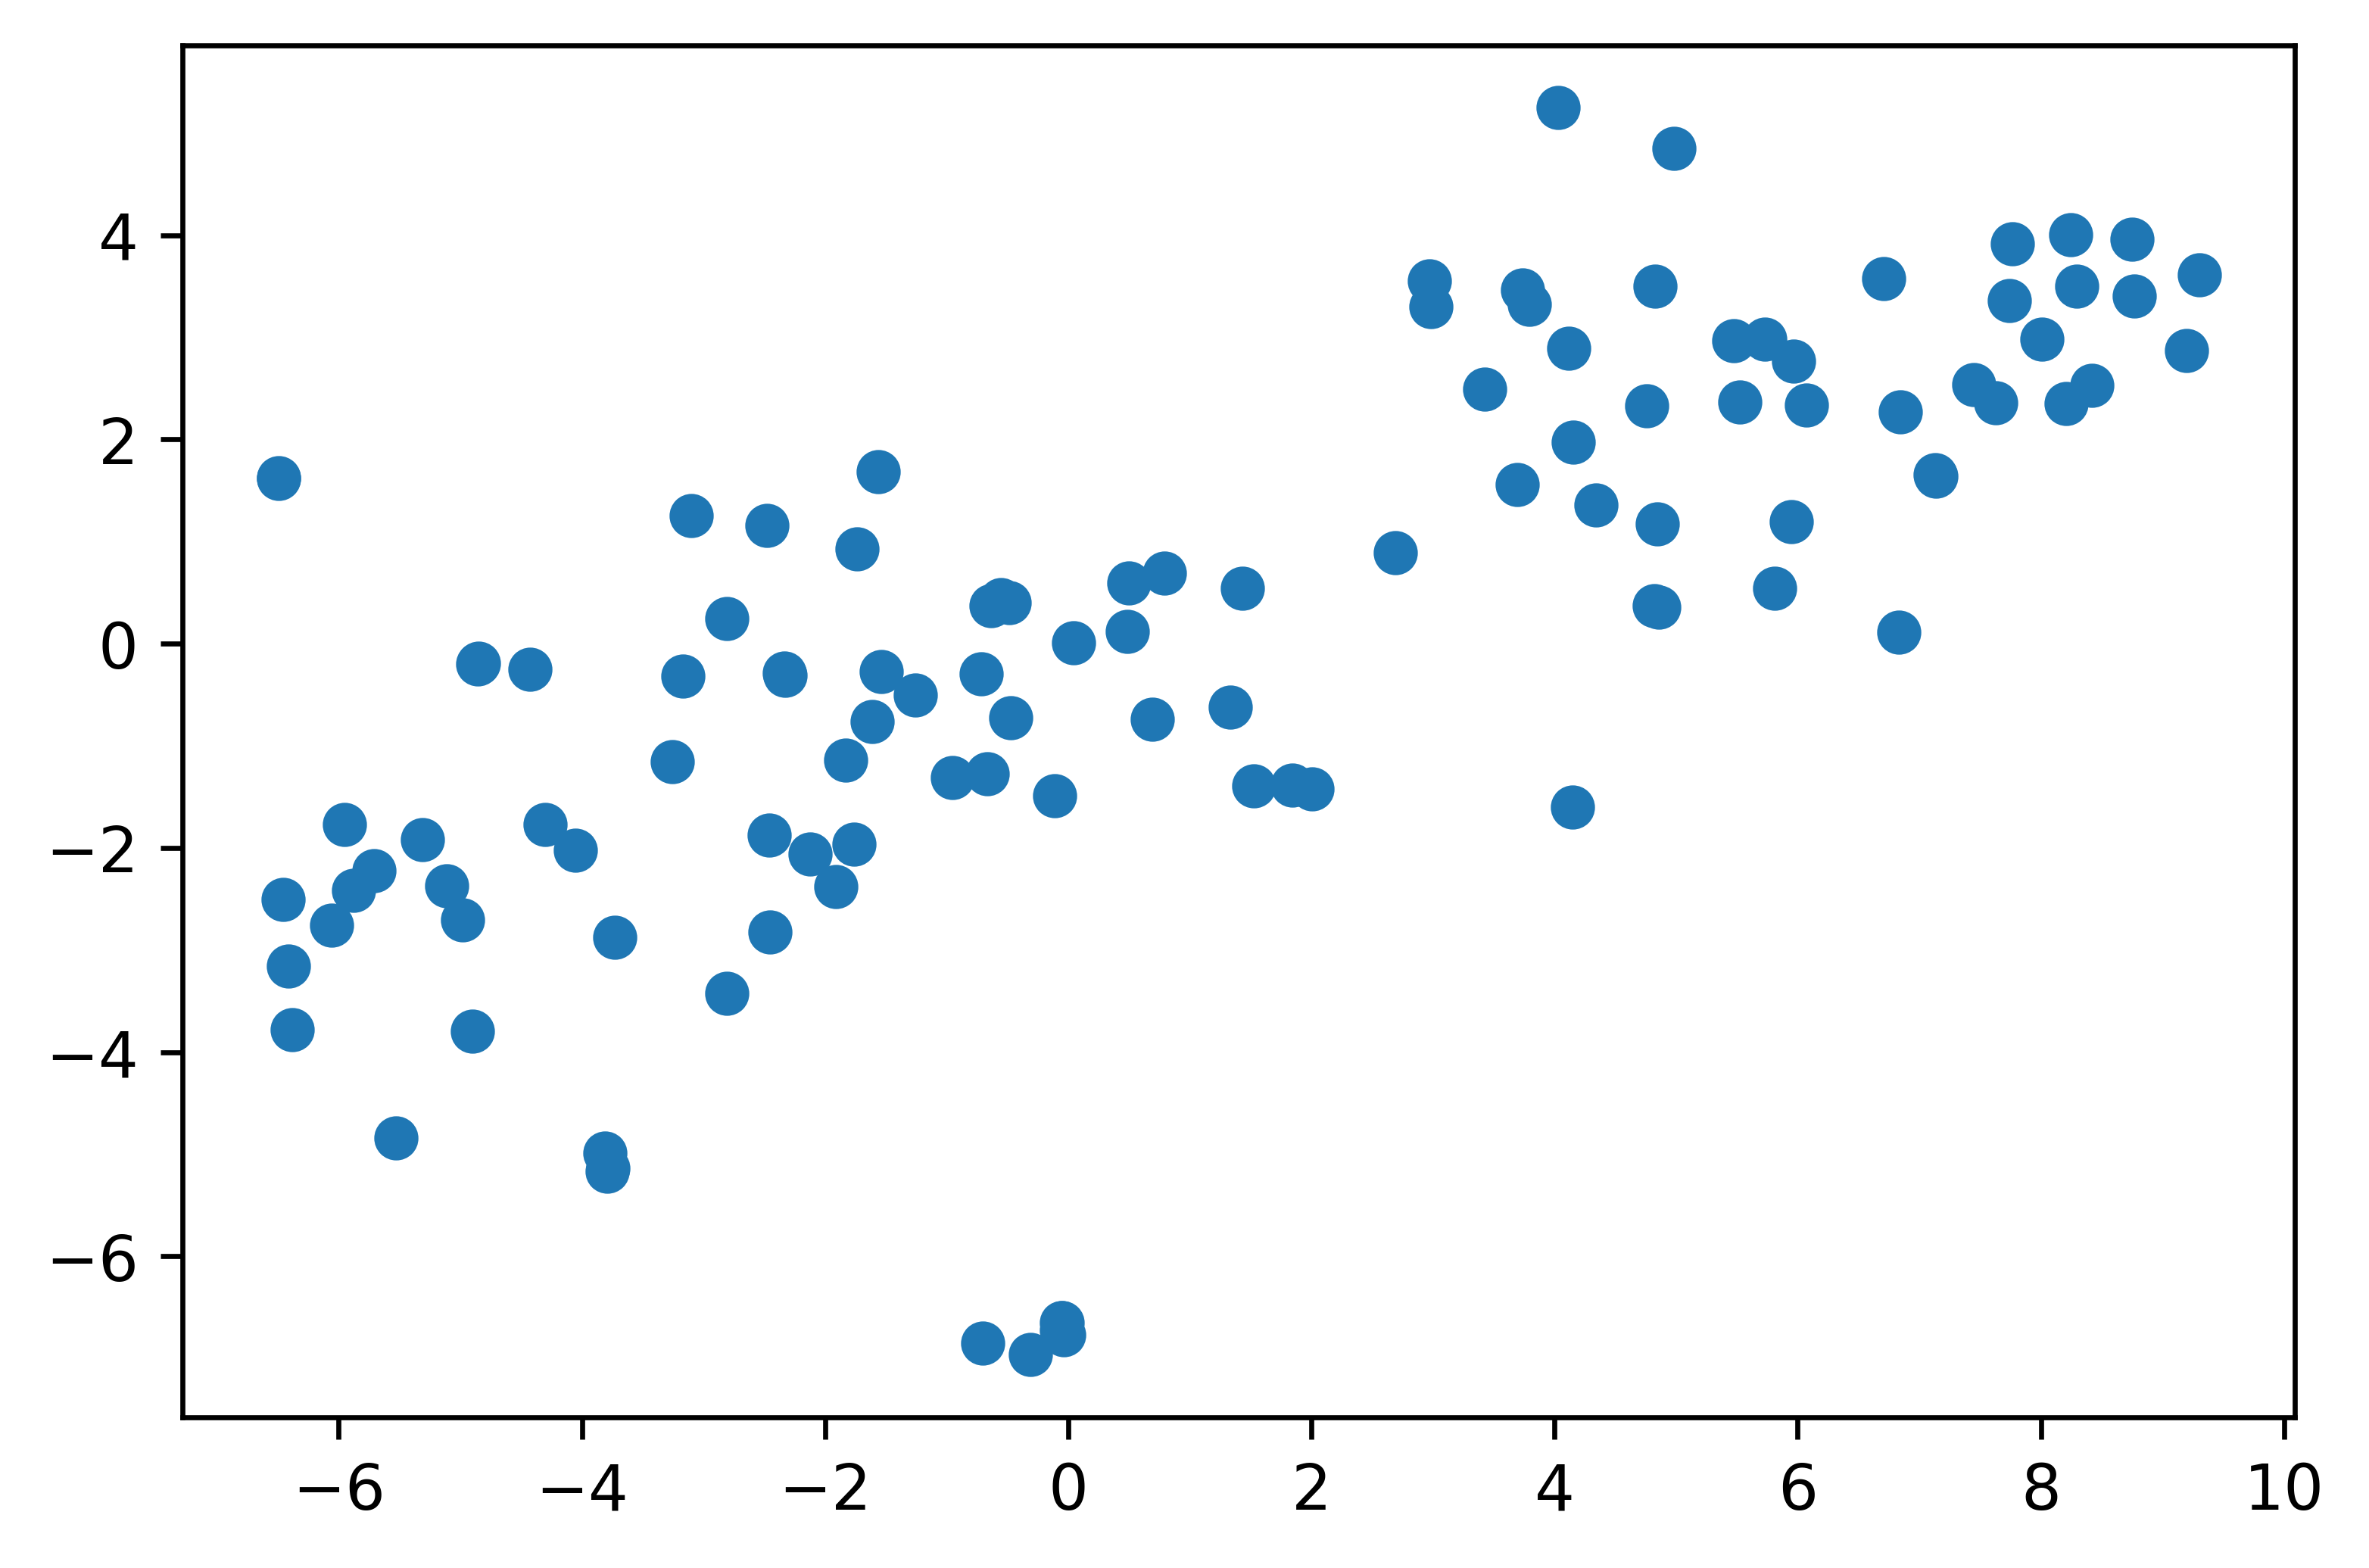

In [6]:
plt.figure(dpi=600)
plt.scatter(vis[:, 0], vis[:, 1])
plt.show()

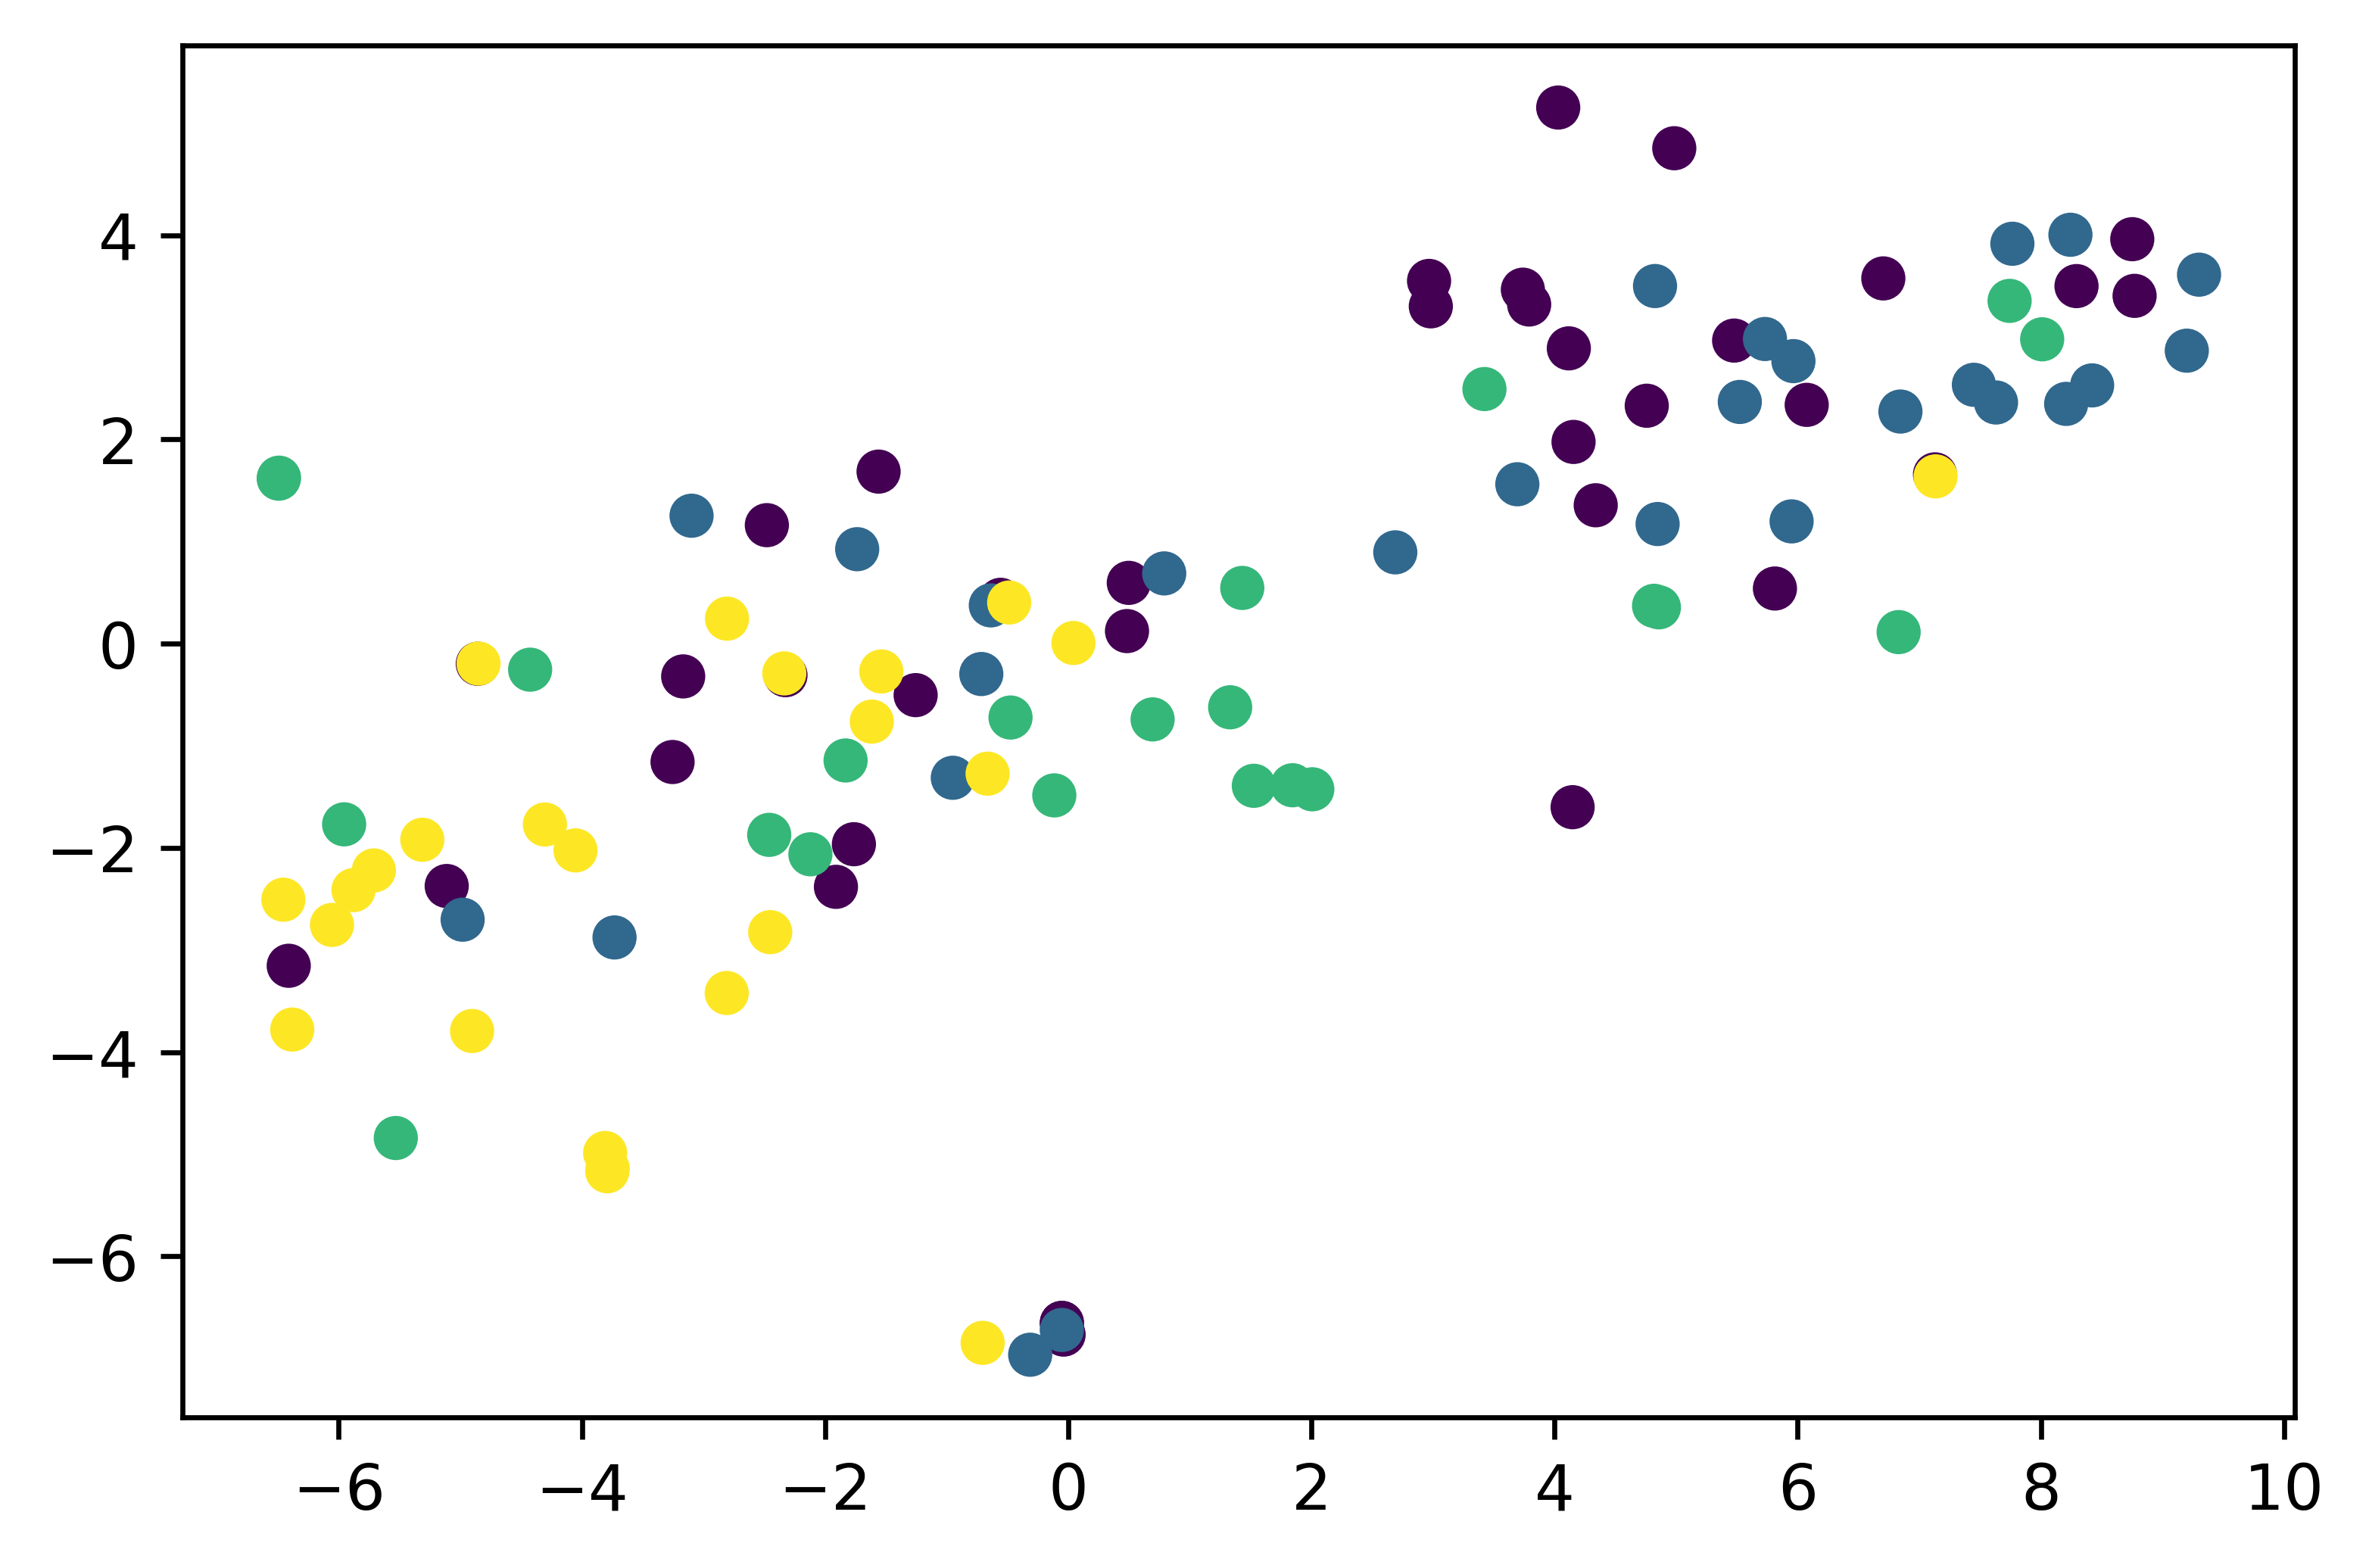

In [7]:
plt.figure(dpi=600)
plt.scatter(vis[:, 0], vis[:, 1], c=y, cmap='viridis')
plt.show()

In [8]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

In [9]:
param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GMM(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(paras)
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)

df=df.sort_values(by="BIC score")
df.head()

,Number of components,Type of covariance,BIC score
3,4,spherical,624.560391
1,2,spherical,662.702281
13,2,diag,673.148523
12,1,diag,676.561909
2,3,spherical,677.007708


In [10]:
n, covartype = df.iloc[0]["Number of components"], \
    df.iloc[0]["Type of covariance"]
print(n, covartype )

4 spherical


In [26]:
ct = ["purple","blue","green", "yellow","red","olive","black"]

In [27]:
cluster_num=6
gmm= GMM(
    n_components=cluster_num,covariance_type=covartype
).fit(paras)
labels = gmm.predict(paras)

0 -- 36
1 -- 6
2 -- 24
3 -- 1
4 -- 40
5 -- 2


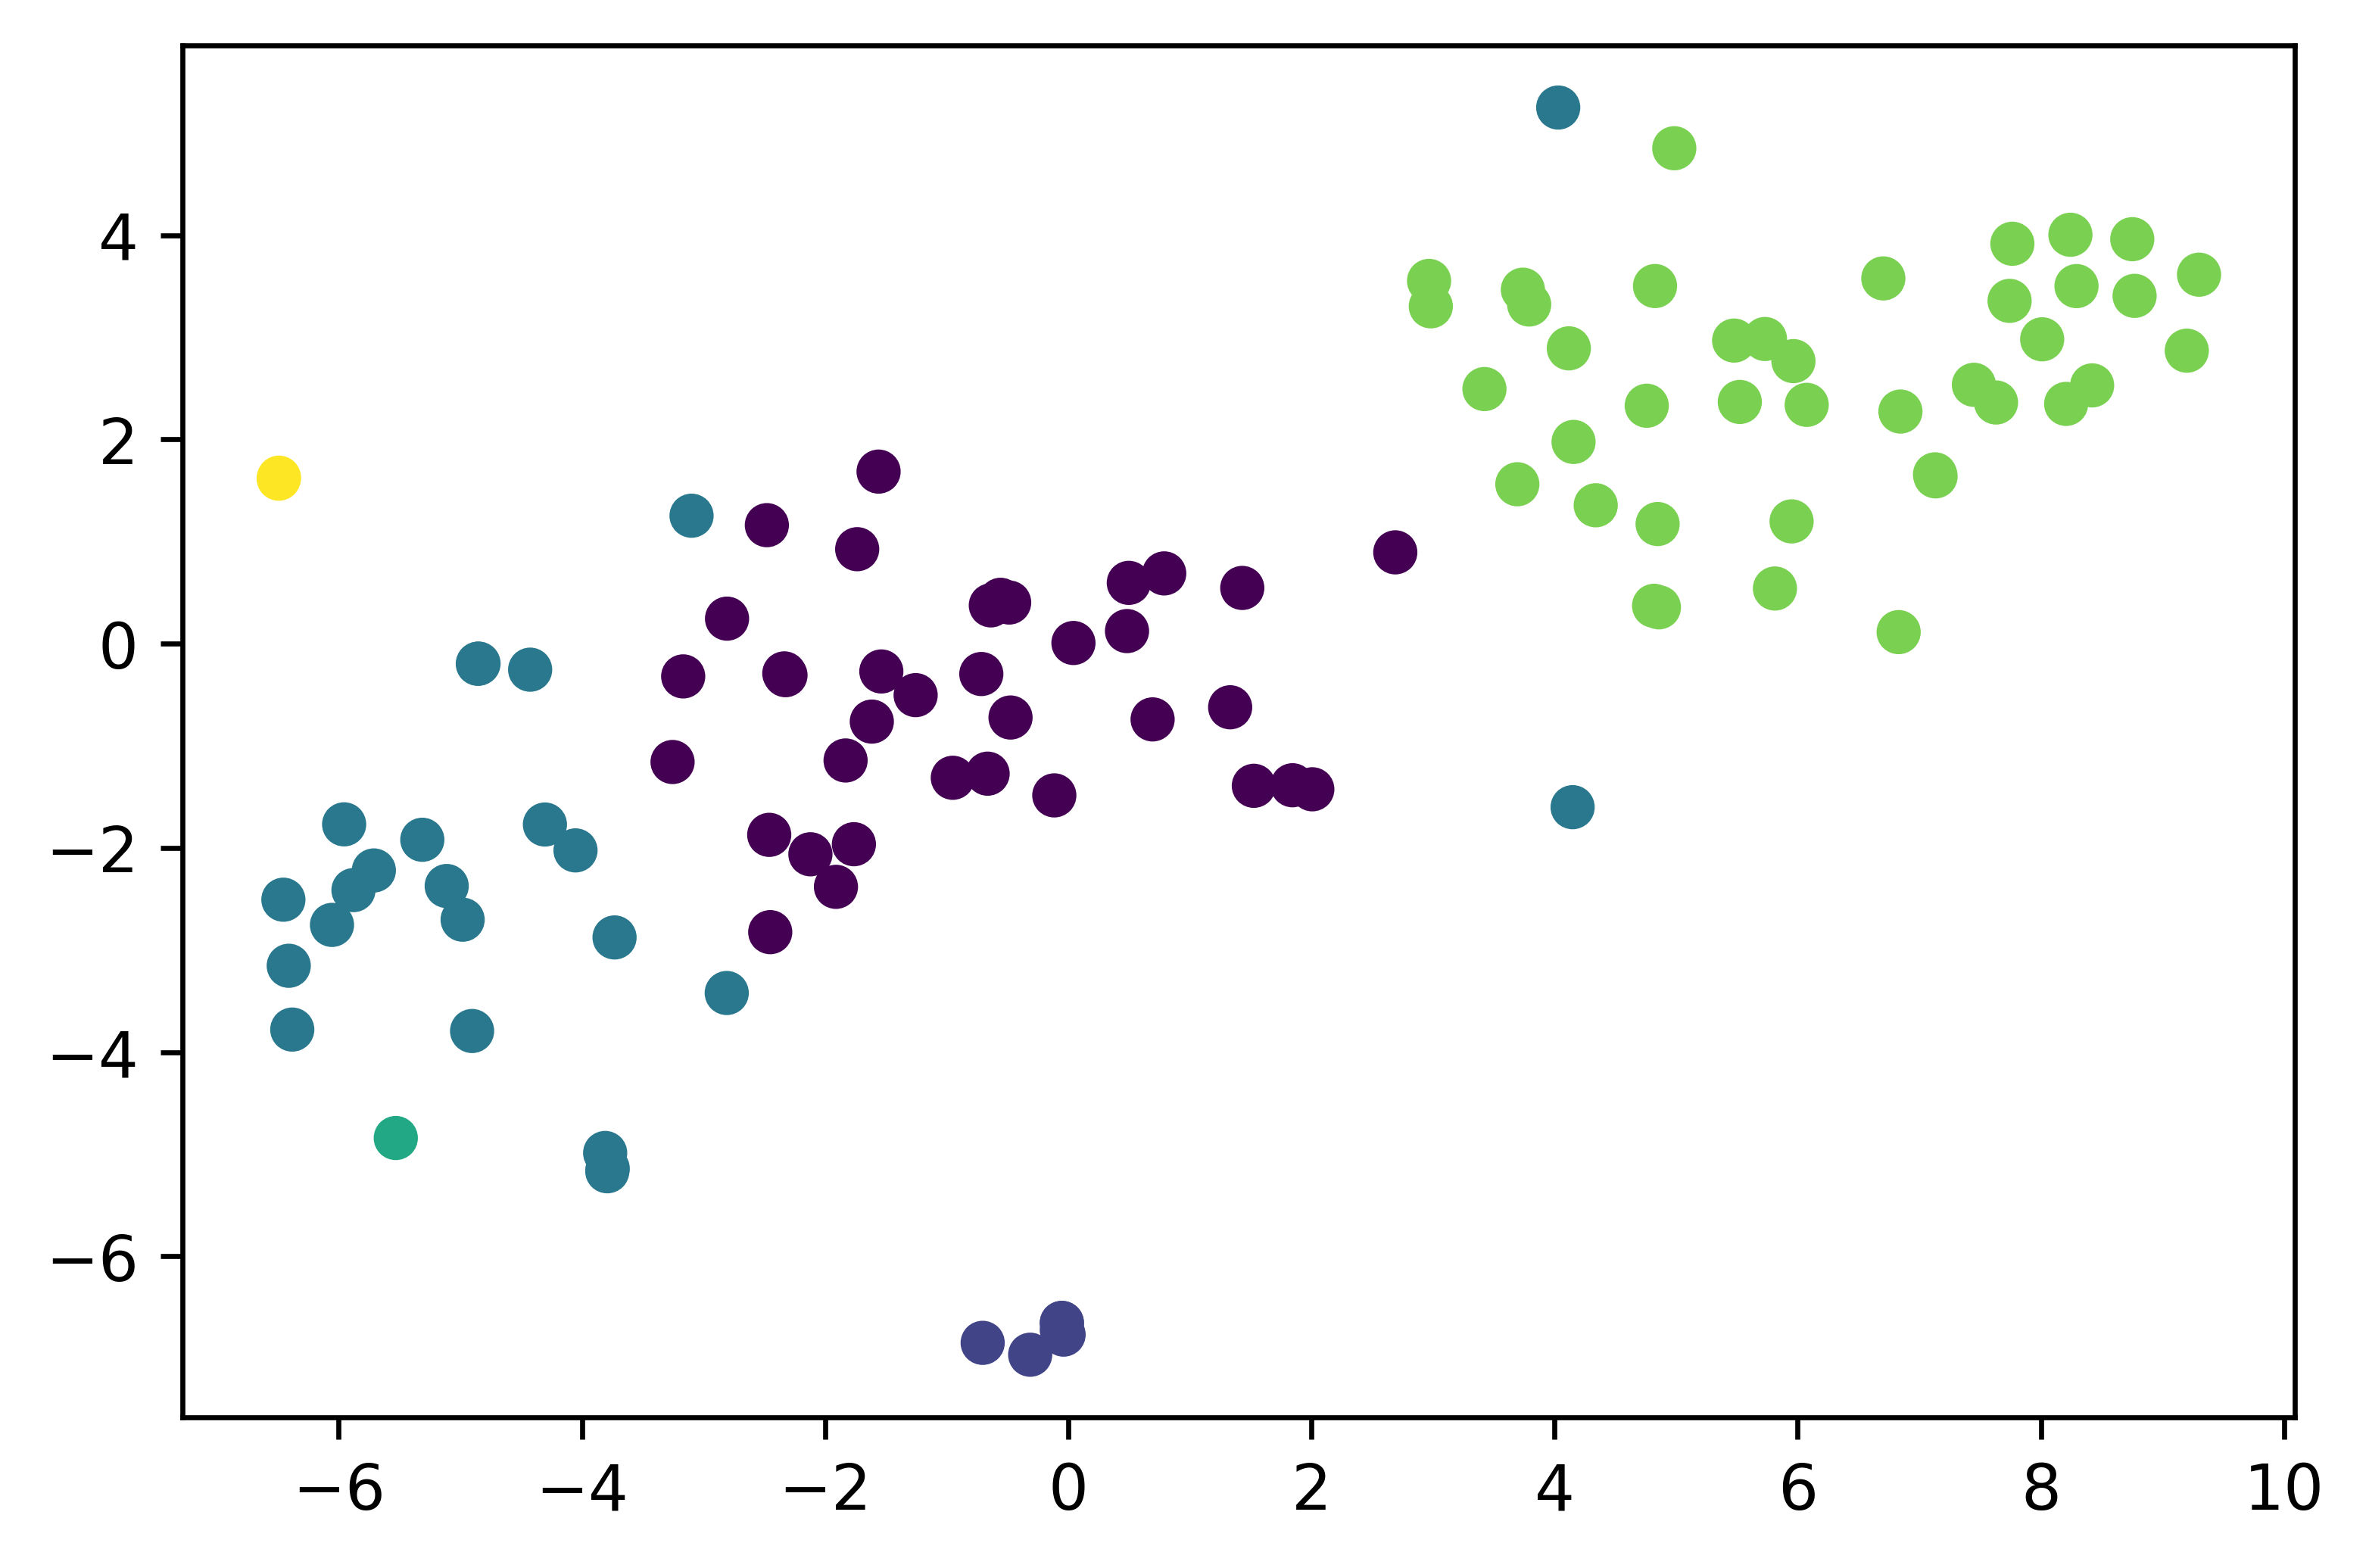

In [28]:
dir = os.path.join("clustering")
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))
    
clustering = {}
for i in range(cluster_num):
    clustering[i] = {}
    clustering[i]["name"] = []
    clustering[i]["idx"] = []

for idx, i in enumerate(labels.tolist()):
        clustering[i]["name"].append(dataname[idx])
        clustering[i]["idx"].append(idx)


for k, v in clustering.items():
    
    plt.figure(dpi = 600)
    with open(
        os.path.join("clustering",f"{k}.txt"),"w+", 
        encoding="utf-8"
    ) as log:
        t =len(v["name"])
        print(f"{k} -- {t}")
        for vi in v["name"]:
            log.write(f"{vi}\n")
        
        for idxi in v["idx"]:
      
            fitl = lines[idxi]
      
            plt.plot(
                list(i for i in range(fitl.shape[0])),
                fitl,color = ct[k]
            )
    plt.ylim(0, 6000)
    plt.savefig(os.path.join("clustering",f"c{k}.jpg"))
    plt.close()

plt.figure(dpi=600)
plt.scatter(vis[:, 0], vis[:, 1], c=labels, cmap='viridis')
plt.show()

In [25]:
for k, v in clustering.items():
    plt.figure(dpi = 600)
    for idxi in v["idx"]:
            fitl = lines[idxi]
            plt.plot(
                list(i for i in range(fitl.shape[0])),
                fitl,color = ct[k]
            )
    
    plt.savefig(os.path.join("clustering",f"zoom_in_{k}.jpg"))
    plt.close()